<a href="https://colab.research.google.com/github/AnthonyCavalcante/cloudwalkcase/blob/main/Case_Pratico_CloudWalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Contexto:

Este estudo de caso simula um cenário de monitoramento voltado à prevenção à lavagem de dinheiro. Ao longo deste notebook, realizaremos o tratamento de um conjunto de dados específico, com o objetivo de conduzir análises relevantes que possam apoiar as equipes de compliance na identificação de padrões atípicos e possíveis indícios de comportamento suspeito.

Este notebook, assim como a apresentação anexa, incluirá um link para um dashboard desenvolvido no Looker. A proposta é oferecer uma visualização clara e objetiva dos dados, facilitando a percepção de padrões e apoiando a tomada de decisões. A construção do dashboard segue uma abordagem de storytelling, permitindo que as informações sejam interpretadas de forma sequencial e estratégica.


Para conduzir este projeto, utilizei um framework organizacional pessoal, que adoto como **"Modelo Everest"**. A estrutura se baseia em uma jornada com etapas estratégicas, comparáveis a uma escalada rumo ao topo da montanha. Cada fase é um ponto crítico a ser alcançado antes de avançar para o próximo desafio, garantindo consistência e foco ao longo do processo. O "topo do Everest", neste contexto, representa a entrega final: todas as respostas requeridas por este estudo de caso.

[Clique aqui](https://lookerstudio.google.com/reporting/1563b96e-2aa7-407e-b5f1-d6be9200ea65) para acessar o Dashboard Analítico do Case

# 2 - Análise Exploratória de Dados

## 2.1 - Importação de Bibliotecas

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

## 2.2 - Carregamento dos dados

In [ ]:
transactions_df = pd.read_excel('ComplianceCaseData1 (2).xlsx', sheet_name='transactions')
merchants_df = pd.read_excel('ComplianceCaseData1 (2).xlsx', sheet_name='merchants')
cnae_statistics_df = pd.read_excel('ComplianceCaseData1 (2).xlsx', sheet_name='CNAE statistcs')

print('Transactions_df')
display(transactions_df.head())
print('Merchants_df')
display(merchants_df.head())
print('Cnae_statistics_df')
display(cnae_statistics_df.head())

Transactions_df


,transaction_id,merchant_id,transaction_date,transaction_time,status,amount,payment_method,capture_method,card_holder_name,card_number
0,123129,1216,2021-03-01,19:00:09,approved,1499.79,debit,emv,123098,498442******3567
1,123130,1229,2021-03-02,16:33:38,approved,1.00,debit,emv,123099,506722******0140
2,123131,1217,2021-03-08,01:25:33,refunded,9896.01,credit,emv,123100,509063******9362
3,123132,1246,2021-03-17,02:08:12,refunded,9996.65,credit,emv,123100,509063******7130
4,123133,1216,2021-02-28,17:48:51,denied,1294.08,credit,emv,123101,520405******0626


Merchants_df


,merchant_id,afiiliation_date,cnae,income,wealth
0,1203,2021-02-06 12:41:31.093,4781400,3000520,6000191
1,1204,2020-01-20 08:22:47.824,4744001,20477,10202
2,1205,2020-08-18 20:38:51.072,4789002,12415,100695
3,1206,2021-02-18 05:35:36.427,7911200,500234,500472
4,1207,2021-02-22 12:35:32.605,4723700,600879,12000117


Cnae_statistics_df


,cnae,average_ticket,average_income,average_wealth
0,4722901,96.92,2409428.47,9288432.39
1,9511800,350.29,878406.91,5381356.70
2,5223100,63.69,364108.19,1271838.55
3,5620101,613.21,435532.00,25691019.48
4,3101200,1523.44,9471501.74,8807774.65


- tipagem das colunas

In [ ]:
transactions_df.info()
print('Dados faltantes:')
transactions_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    9391 non-null   int64         
 1   merchant_id       9391 non-null   int64         
 2   transaction_date  9391 non-null   datetime64[ns]
 3   transaction_time  9391 non-null   object        
 4   status            9391 non-null   object        
 5   amount            9391 non-null   float64       
 6   payment_method    9391 non-null   object        
 7   capture_method    9391 non-null   object        
 8   card_holder_name  9391 non-null   int64         
 9   card_number       9391 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(5)
memory usage: 733.8+ KB
Dados faltantes:


,0
transaction_id,0
merchant_id,0
transaction_date,0
transaction_time,0
status,0
amount,0
payment_method,0
capture_method,0
card_holder_name,0
card_number,0


In [ ]:
merchants_df.info()
print('Dados faltantes:')
merchants_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   merchant_id       48 non-null     int64         
 1   afiiliation_date  48 non-null     datetime64[ns]
 2   cnae              48 non-null     int64         
 3   income            48 non-null     int64         
 4   wealth            48 non-null     int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 2.0 KB
Dados faltantes:


,0
merchant_id,0
afiiliation_date,0
cnae,0
income,0
wealth,0


In [ ]:
cnae_statistics_df.info()
print('Dados faltantes:')
cnae_statistics_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cnae            35 non-null     int64  
 1   average_ticket  35 non-null     float64
 2   average_income  35 non-null     float64
 3   average_wealth  35 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 1.2 KB
Dados faltantes:


,0
cnae,0
average_ticket,0
average_income,0
average_wealth,0


## 2.3 - Adicionando novas colunas

### transactions_df

In [ ]:
transactions_df['transaction_hour'] = transactions_df['transaction_time'].apply(lambda t: t.hour)

transactions_df['transaction_weekday'] = transactions_df['transaction_date'].apply(
    lambda weekday : pd.to_datetime(weekday).day_name())

transactions_df['is_weekend'] = transactions_df['transaction_weekday'].apply(
    lambda day : 1 if day in ['Saturday', 'Sunday'] else 0)

transactions_df['amount_per_card_mean'] = transactions_df.groupby('card_number')['amount'].transform('mean')
transactions_df['amount_per_merchant_mean'] = transactions_df.groupby('merchant_id')['amount'].transform('mean')


- Reorganizar coluna

In [ ]:
transactions_df = transactions_df[['transaction_id', 'merchant_id','status',
                                    'payment_method', 'capture_method','card_holder_name',
                                    'card_number','amount','amount_per_card_mean','amount_per_merchant_mean',
                                    'transaction_date','transaction_time','transaction_hour',
                                    'transaction_weekday','is_weekend']]

In [ ]:
transactions_df.head()

,transaction_id,merchant_id,status,payment_method,capture_method,card_holder_name,card_number,amount,amount_per_card_mean,amount_per_merchant_mean,transaction_date,transaction_time,transaction_hour,transaction_weekday,is_weekend
0,123129,1216,approved,debit,emv,123098,498442******3567,1499.79,1499.790000,357.119444,2021-03-01,19:00:09,19,Monday,0
1,123130,1229,approved,debit,emv,123099,506722******0140,1.00,1.000000,9238.962500,2021-03-02,16:33:38,16,Tuesday,0
2,123131,1217,refunded,credit,emv,123100,509063******9362,9896.01,9953.203333,9360.962353,2021-03-08,01:25:33,1,Monday,0
3,123132,1246,refunded,credit,emv,123100,509063******7130,9996.65,9976.209750,9992.425789,2021-03-17,02:08:12,2,Wednesday,0
4,123133,1216,denied,credit,emv,123101,520405******0626,1294.08,1294.480000,357.119444,2021-02-28,17:48:51,17,Sunday,1


- Criando coluna de risk_score

In [ ]:
amount_mean = transactions_df['amount'].mean()
amount_std = transactions_df['amount'].std()

merchant_mean = transactions_df['amount_per_merchant_mean'].mean()
merchant_std = transactions_df['amount_per_merchant_mean'].std()

def calculate_risk_score(row):
    score = 0

      # `transaction_hour_risk`
    hour = row['transaction_hour']
    if 0 <= hour < 6:
        score += 1
    elif 6 <= hour < 9 or 18 <= hour < 24:
        score += 1

    # `weekend_transaction_risk`
    if row['is_weekend'] == 1:
        score += 1

    # `amount_risk`
    amount_zscore = (row['amount'] - amount_mean) / amount_std
    if amount_zscore > 2:
        score += 1

    # `merchant_risk`
    merchant_zscore = (row['amount_per_merchant_mean'] - merchant_mean) / merchant_std
    if merchant_zscore > 1:
        score += 1

    # `payment_method_risk`
    if row['payment_method'] == 'credit':
        score += 1

    return score + 1  # Ensure minimum score is 1

- aplicando risk_score_function e criand oa coluna de risk_score

In [ ]:
transactions_df['risk_score'] = transactions_df.apply(calculate_risk_score, axis=1)

In [ ]:
max_risk_score = transactions_df['risk_score'].max()
min_risk_score = transactions_df['risk_score'].min()

interval_size = (max_risk_score - min_risk_score) / 3

low_risk_limit = min_risk_score + interval_size
moderate_risk_limit = low_risk_limit + interval_size

transactions_df['risk_level'] = transactions_df['risk_score'].apply( lambda
                            value : 'high' if value >= moderate_risk_limit else
                            ('moderate' if value >= low_risk_limit else 'low'))

In [ ]:
transactions_df.head(10)

,transaction_id,merchant_id,status,payment_method,capture_method,card_holder_name,card_number,amount,amount_per_card_mean,amount_per_merchant_mean,transaction_date,transaction_time,transaction_hour,transaction_weekday,is_weekend,risk_score,risk_level
0,123129,1216,approved,debit,emv,123098,498442******3567,1499.79,1499.790000,357.119444,2021-03-01,19:00:09,19,Monday,0,2,low
1,123130,1229,approved,debit,emv,123099,506722******0140,1.00,1.000000,9238.962500,2021-03-02,16:33:38,16,Tuesday,0,2,low
2,123131,1217,refunded,credit,emv,123100,509063******9362,9896.01,9953.203333,9360.962353,2021-03-08,01:25:33,1,Monday,0,4,high
3,123132,1246,refunded,credit,emv,123100,509063******7130,9996.65,9976.209750,9992.425789,2021-03-17,02:08:12,2,Wednesday,0,4,high
4,123133,1216,denied,credit,emv,123101,520405******0626,1294.08,1294.480000,357.119444,2021-02-28,17:48:51,17,Sunday,1,3,moderate
5,123134,1206,approved,credit,emv,123100,509063******8986,9985.23,9978.118919,9621.382143,2021-03-03,19:02:04,19,Wednesday,0,4,high
6,123135,1216,approved,credit,emv,123102,548474******6029,396.38,396.380000,357.119444,2021-02-04,14:32:39,14,Thursday,0,2,low
7,123136,1224,approved,credit,emv,123103,552289******6495,9493.81,9493.810000,4970.418333,2021-02-03,17:29:33,17,Wednesday,0,2,low
8,123137,1206,approved,credit,emv,123100,509063******8614,9982.44,9966.525294,9621.382143,2021-03-03,01:49:56,1,Wednesday,0,4,high
9,123138,1206,refunded,credit,emv,123100,509063******8986,9990.24,9978.118919,9621.382143,2021-03-03,19:01:06,19,Wednesday,0,4,high


### merchant_df

In [ ]:
merchants_df['years_since_affiliation'] = (pd.to_datetime('now') - pd.to_datetime(merchants_df['afiiliation_date'])).dt.days / 365


## 2.4 União das Tabelas

In [ ]:
transactions_merchants_cnae_df = pd.merge(transactions_df, merchants_df, on='merchant_id', how='left')

transactions_merchants_cnae_df= pd.merge(transactions_merchants_cnae_df, cnae_statistics_df, on='cnae', how='left')

transactions_merchants_cnae_df.head()

,transaction_id,merchant_id,status,payment_method,capture_method,card_holder_name,card_number,amount,amount_per_card_mean,amount_per_merchant_mean,...,risk_score,risk_level,afiiliation_date,cnae,income,wealth,years_since_affiliation,average_ticket,average_income,average_wealth
0,123129,1216,approved,debit,emv,123098,498442******3567,1499.79,1499.790000,357.119444,...,2,low,2020-09-15 09:52:08.213,4520001,200067,1500137,4.572603,592.40,4740726.38,11222319.06
1,123130,1229,approved,debit,emv,123099,506722******0140,1.00,1.000000,9238.962500,...,2,low,2021-02-25 10:48:25.223,4723700,543,260,4.126027,110.45,1282059.92,4814925.51
2,123131,1217,refunded,credit,emv,123100,509063******9362,9896.01,9953.203333,9360.962353,...,4,high,2021-02-18 08:36:08.775,3101200,200911,400912,4.145205,1523.44,9471501.74,8807774.65
3,123132,1246,refunded,credit,emv,123100,509063******7130,9996.65,9976.209750,9992.425789,...,4,high,2021-03-05 05:46:59.102,4755501,3,111,4.104110,245.11,9637770.64,24015359.14
4,123133,1216,denied,credit,emv,123101,520405******0626,1294.08,1294.480000,357.119444,...,3,moderate,2020-09-15 09:52:08.213,4520001,200067,1500137,4.572603,592.40,4740726.38,11222319.06


### Tratamento e limpeza de dados

In [ ]:
#verificando tipo das colunas
transactions_merchants_cnae_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9391 entries, 0 to 9390
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   transaction_id            9391 non-null   int64         
 1   merchant_id               9391 non-null   int64         
 2   status                    9391 non-null   object        
 3   payment_method            9391 non-null   object        
 4   capture_method            9391 non-null   object        
 5   card_holder_name          9391 non-null   int64         
 6   card_number               9391 non-null   object        
 7   amount                    9391 non-null   float64       
 8   amount_per_card_mean      9391 non-null   float64       
 9   amount_per_merchant_mean  9391 non-null   float64       
 10  transaction_date          9391 non-null   datetime64[ns]
 11  transaction_time          9391 non-null   object        
 12  transaction_hour    

In [ ]:
#verificando se existe valores nulos
transactions_merchants_cnae_df.isnull().sum()

,0
transaction_id,0
merchant_id,0
status,0
payment_method,0
capture_method,0
card_holder_name,0
card_number,0
amount,0
amount_per_card_mean,0
amount_per_merchant_mean,0


In [ ]:
#valores duplicados
transactions_merchants_cnae_df.duplicated().sum()

np.int64(0)

### Adicionando novas colunas

In [ ]:
avg_amount_per_merchant = transactions_merchants_cnae_df.groupby('merchant_id')['amount'].mean().reset_index()
avg_amount_per_merchant.rename(columns={'amount': 'avg_transaction_amount'}, inplace=True)

# Merge the average amount per merchant back into the main DataFrame
transactions_merchants_cnae_df = pd.merge(transactions_merchants_cnae_df, avg_amount_per_merchant, on='merchant_id', how='left')

# Calculate the compatibility index
transactions_merchants_cnae_df['compatibility_index'] = transactions_merchants_cnae_df['avg_transaction_amount'] / transactions_merchants_cnae_df['income']

# Calculate quartiles for compatibility_index
q1 = transactions_merchants_cnae_df['compatibility_index'].quantile(0.25)
q3 = transactions_merchants_cnae_df['compatibility_index'].quantile(0.75)

# Define the function to categorize compatibility
def categorize_compatibility(index):
    if index < q1:
        return 'Alta Compatibilidade'
    elif index >= q1 and index < q3:
        return 'Atenção'
    else:
        return 'Baixa Compatibilidade'

# Create the new column
transactions_merchants_cnae_df['compatibility_level'] = transactions_merchants_cnae_df['compatibility_index'].apply(categorize_compatibility)

In [ ]:
# Calculate total transactions per merchant
total_transactions_per_merchant = transactions_merchants_cnae_df.groupby('merchant_id').size().reset_index(name='total_transactions')

# Calculate refunded transactions per merchant
refunded_transactions_per_merchant = transactions_merchants_cnae_df[transactions_merchants_cnae_df['status'] == 'refunded'].groupby('merchant_id').size().reset_index(name='refunded_transactions')

# Merge the two DataFrames
refund_rate_df = pd.merge(total_transactions_per_merchant, refunded_transactions_per_merchant, on='merchant_id', how='left').fillna(0)

# Calculate refund rate
refund_rate_df['refund_rate'] = refund_rate_df['refunded_transactions'] / refund_rate_df['total_transactions']

# Merge refund rate back into the main DataFrame
transactions_merchants_cnae_df = pd.merge(transactions_merchants_cnae_df, refund_rate_df[['merchant_id', 'refund_rate']], on='merchant_id', how='left').fillna(0)

In [ ]:
def count_transactions_by_risk_level(df, risk_level):
     """Counts the number of transactions for each merchant at a given risk level."""
     return df[df['risk_level'] == risk_level].groupby('merchant_id').size().reset_index(name=f'{risk_level}_risk_transactions')

   # Calculate high, moderate, and low risk transaction counts
high_risk_counts = count_transactions_by_risk_level(transactions_merchants_cnae_df, 'high')
moderate_risk_counts = count_transactions_by_risk_level(transactions_merchants_cnae_df, 'moderate')
low_risk_counts = count_transactions_by_risk_level(transactions_merchants_cnae_df, 'low')

# Merge the counts back into the main DataFrame
transactions_merchants_cnae_df = pd.merge(transactions_merchants_cnae_df, high_risk_counts, on='merchant_id', how='left').fillna(0)
transactions_merchants_cnae_df = pd.merge(transactions_merchants_cnae_df, moderate_risk_counts, on='merchant_id', how='left').fillna(0)
transactions_merchants_cnae_df = pd.merge(transactions_merchants_cnae_df, low_risk_counts, on='merchant_id', how='left').fillna(0)


In [ ]:
transactions_merchants_cnae_df.head()

,transaction_id,merchant_id,status,payment_method,capture_method,card_holder_name,card_number,amount,amount_per_card_mean,amount_per_merchant_mean,...,average_ticket,average_income,average_wealth,avg_transaction_amount,compatibility_index,compatibility_level,refund_rate,high_risk_transactions,moderate_risk_transactions,low_risk_transactions
0,123129,1216,approved,debit,emv,123098,498442******3567,1499.79,1499.790000,357.119444,...,592.40,4740726.38,11222319.06,357.119444,0.001785,Atenção,0.000000,1.0,16.0,19.0
1,123130,1229,approved,debit,emv,123099,506722******0140,1.00,1.000000,9238.962500,...,110.45,1282059.92,4814925.51,9238.962500,17.014664,Baixa Compatibilidade,0.357143,26.0,1.0,1.0
2,123131,1217,refunded,credit,emv,123100,509063******9362,9896.01,9953.203333,9360.962353,...,1523.44,9471501.74,8807774.65,9360.962353,0.046593,Baixa Compatibilidade,0.176471,13.0,3.0,1.0
3,123132,1246,refunded,credit,emv,123100,509063******7130,9996.65,9976.209750,9992.425789,...,245.11,9637770.64,24015359.14,9992.425789,3330.808596,Baixa Compatibilidade,0.368421,19.0,0.0,0.0
4,123133,1216,denied,credit,emv,123101,520405******0626,1294.08,1294.480000,357.119444,...,592.40,4740726.38,11222319.06,357.119444,0.001785,Atenção,0.000000,1.0,16.0,19.0


### Nova Tabela com Falso positivo e Falso **negativo**

In [ ]:
# Criar a coluna 'predicted_risk_level' (Simplificação: usar a própria 'risk_level')
transactions_merchants_cnae_df['predicted_risk_level'] = transactions_merchants_cnae_df['risk_level']

# Calcular TP, TN, FP, FN
TP = len(transactions_merchants_cnae_df[(transactions_merchants_cnae_df['risk_level'] == 'high') & (transactions_merchants_cnae_df['predicted_risk_level'] == 'high')])
TN = len(transactions_merchants_cnae_df[(transactions_merchants_cnae_df['risk_level'] != 'high') & (transactions_merchants_cnae_df['predicted_risk_level'] != 'high')])
FP = len(transactions_merchants_cnae_df[(transactions_merchants_cnae_df['risk_level'] != 'high') & (transactions_merchants_cnae_df['predicted_risk_level'] == 'high')])
FN = len(transactions_merchants_cnae_df[(transactions_merchants_cnae_df['risk_level'] == 'high') & (transactions_merchants_cnae_df['predicted_risk_level'] != 'high')])

# Calcular Precision, Recall, Accuracy, F1-score
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
accuracy = (TP + TN) / len(transactions_merchants_cnae_df)
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Adicionar as métricas como uma nova linha no DataFrame (para visualização)
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'Accuracy', 'F1-score', 'TP', 'TN', 'FP', 'FN'],
    'Value': [precision, recall, accuracy, f1, TP, TN, FP, FN]
})



## 2.5 Exportando Tabela para visualização de Dados

In [ ]:
transactions_merchants_cnae_df.to_csv('transations_merchant_cnae.csv', index=False)
metrics_df.to_csv('metrics.csv', index=False)

## 2.6 - Aplicando Machine Learning para classificação de risco

## Random Forest

In [ ]:
features = [
    'amount', 'transaction_hour', 'is_weekend', 'amount_per_merchant_mean',
    'income', 'wealth', 'years_since_affiliation', 'average_ticket',
    'average_income', 'average_wealth', 'compatibility_index', 'refund_rate'
]
data = transactions_merchants_cnae_df[features + ['risk_level', 'payment_method', 'capture_method']].copy()

# 1.2. Codificar Variáveis Categóricas (se necessário):
data = pd.get_dummies(data, columns=['payment_method', 'capture_method'], drop_first=True, dummy_na=False)

# 1.3. Converter a Coluna Alvo:
data['risk_level'] = data['risk_level'].map({'low': 0, 'moderate': 1, 'high': 2})

# 1.4. Remover Valores Ausentes:
data = data.dropna()

## Prepaprando caracteristicas  e treinndo o modelo

In [ ]:
X = data.drop('risk_level', axis=1)
y = data['risk_level']

# 1.6. Dividir em Treino e Teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Passo 2: Treinar o Modelo
# 2.1. Criar o Modelo:
model = RandomForestClassifier(random_state=42)

# 2.2. Treinar o Modelo:
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

- Criar o Explainer

Apresenta como cada característica são mais importantes para o modelo geral

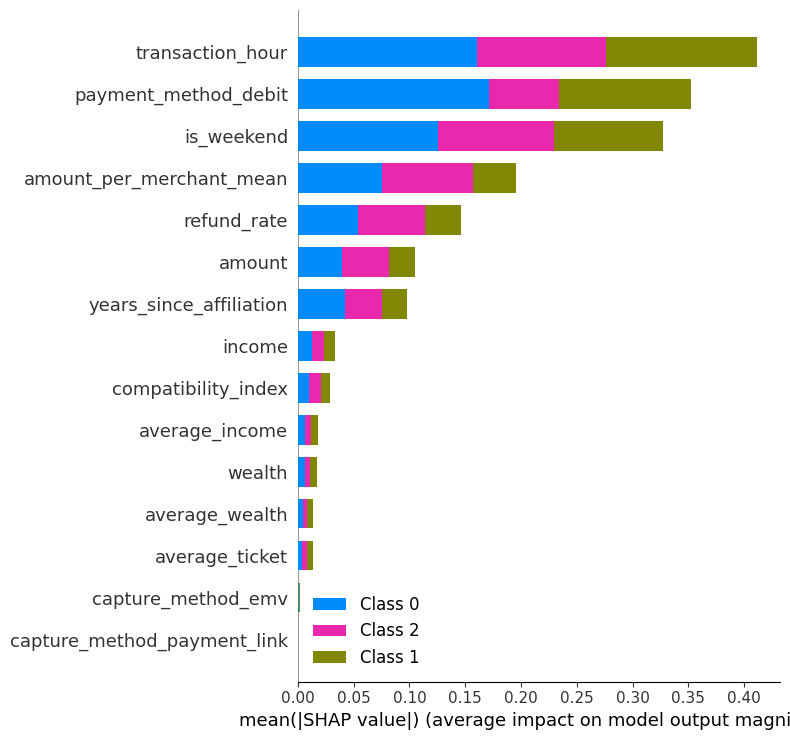

In [ ]:
explainer = shap.TreeExplainer(model)

# 3.2. Calcular os Valores SHAP:
shap_values = explainer.shap_values(X_test)

# Passo 4: Visualizar e Interpretar
# 4.1. Gráfico de Importância de Características:
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=X_test.columns)
plt.show()